### Query SDSS DR12 for interesting objects, create a URL for retrieving a JPG cutout, show these and store them on SciDrive from which they can be served to world via public URL.

This demo show cases various components of SciServer and in particular how SciServer/Compute (i.e. Jupyter notebooks) allow one to communicate with these. IN particular:
1. Single-sign-on authentication through Keystone tokens
1. import special purpose libraries written for SciServer actions
1. Querying relational databases registered in CasJobs (SciServer's database frontend and batch query engine)
1. Manipulating query results in python code (visualization)
1. Storing results on local scratch disk as an HDF5 file for later reuse
1. Alternatively, storing query result in one's private database, MyDB
1. Based on query result retrieve images from persistents store, available to notebook because the docker container was created with a link to the corresponding volume container and show the images on the screen.
1. Write images to the sharable, dropbox-like SciDrive. There they can be found through the UI interface and shared with colleagues.

# 1. SSO with Keystone tokens
When opening one's docker container from the sciserver/compute Dashboard page, the current token will be written in the file /home/idies/keystone.token. <br/>The next block of code reads the token and stores it in a local variable. Alternatively one may find the current token on the Dashbooard.<br/>
Note, since the token may expire, it is up to the user to now and then refresh the token. This may simply be done by refreshing the token on the Dashboard and rerunnning the next block.

In [75]:
# standard first block for defining the token and makinhg it available as a system variable for the session
# token must be replaced with new one once it has expired
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')
print(token)

0abf09087b714de3b8093ea334760ee3


# 2. Import SciServer libraries 
The SciServer team has written a number of libraries, generally prefixed by <tt>SciServer</tt>, that assist in various functions. The next block imports those, together with some standard python libraries. 

In [76]:
import SciServer.CasJobs as CasJobs
import SciServer.SciDrive
import numpy as np
import pandas
import matplotlib.pyplot as plt
import skimage.io
import urllib
import json

In [77]:
# some special settings
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')

# 3. Query an astronomy database (SDSS/DR12)
Write SQL statement and send it to CasJobs' REST API. Uses synchronous mode as the query is quite small. asynch mode is available, this will submit job to queue and the result will be stored in a table in MyDB or MyScratch/DB. 

TODO make example with batch query mode.

In [78]:
# query obtained from SkyServer interface
# Queries the Sloan Digital Sky Survey's Data Release 12.
# For schema and documentation see http://skyserver.sdss.org
#
# This query finds galaxies in the SDSS database that have a spectrum taken and which have a size (petror90_r)
# larger than 10 arcsec.
# We return 
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""

# query CasJobs table. Using DR12 as context. I.e. a connection is made to DR12 when running the query.
queryResponse = CasJobs.executeQuery(query, "dr12",token=token)
# parse results into pandas.DataFrame for further in memory processing
gals = pandas.read_csv(queryResponse,index_col=0)

executeQuery POST response:  200 OK


In [79]:
# show the table
gals

,ra,dec,petror90_r
objId,,,
1237645941824356443,40.285690,-0.714957,14.72862
1237645943978393694,55.123625,0.872487,18.85110
1237645943979114622,56.847420,0.875488,15.66479
1237645943979311221,57.248385,0.925979,14.60275
1237646588246688297,80.135126,1.186679,11.14294
1237648672921485632,243.708876,-0.915653,15.01578
1237648672922337955,245.700633,-0.844301,10.51866
1237648672922468973,246.015172,-0.902869,10.80825
1237648673459077169,245.367353,-0.457074,11.18379


# 4. Simple Plot

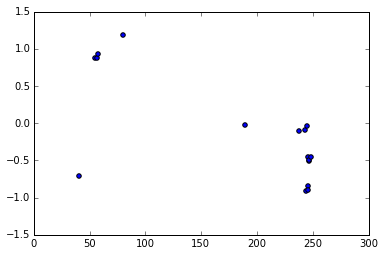

In [80]:
plt.scatter(gals['ra'], gals['dec'])
plt.show() 

# 5. Storing results on local scratch disk as an HDF5 file for later reuse
After running the next script view the folder <tt>persistent/science demos/</tt> of the Jupyter notebook to see the files.

In [81]:
# store result as HDF5 file 
h5store = pandas.HDFStore('GalaxyThumbSample.h5')
h5store['galaxies']=gals
h5store.close()

# store result as CSV file
gals.to_csv('GalaxyThumbSample.csv')

# 7. Retrieve cut-outs/thumbnails of galaxies and show them on screen
SkyServer has a service that will produce a JPG cut-out of certain dimensions around a specified position. It uses a pre-defined image pyramid for this. We can construct the URL of the service form the query results and retrieve the images using standard python functions. We use the Petrosian radius along with the pixel size and desired width to set the appropriate scale for each cutout so as to produce a postage stamp image of each object.

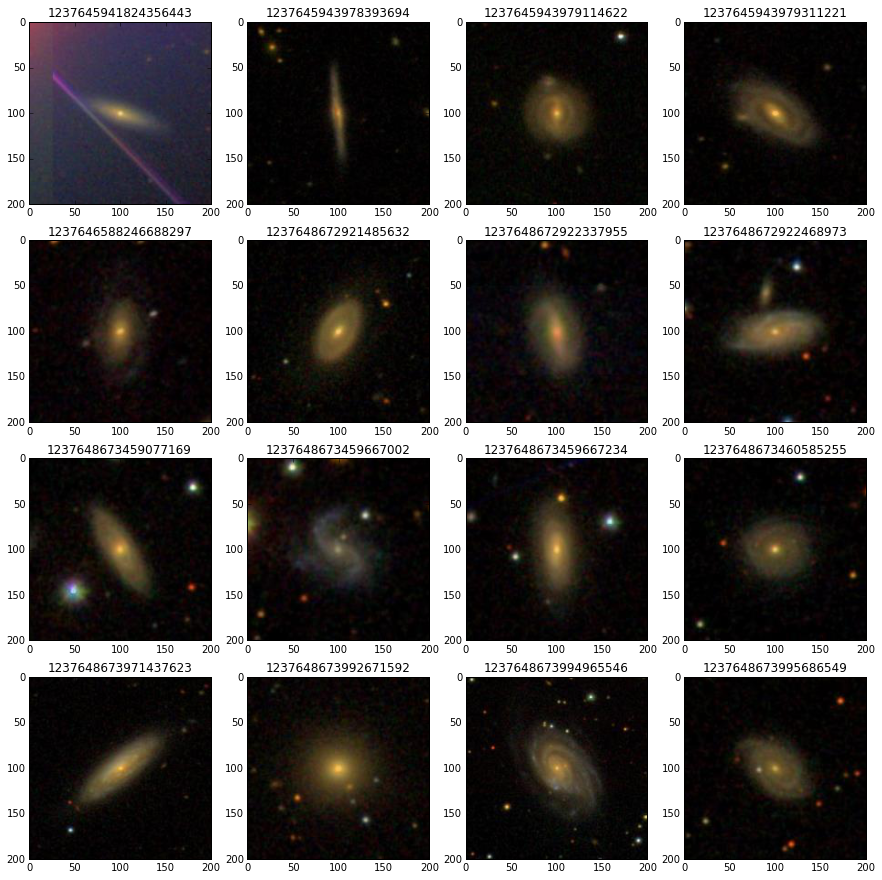

In [71]:
width=200
height=200
pixelsize=0.396
plt.figure(figsize=(15, 15))
subPlotNum = 1

for index,gal in gals.iterrows():
    scale=2*gal['petror90_r']/pixelsize/width
    url="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    img=skimage.io.imread(url)
    plt.subplot(4,4,subPlotNum)
    subPlotNum += 1
    plt.imshow(img)
    # show the object identifier (objId) above the image.
    plt.title(index)


# 8. Write thumbnails to SciDrive
### Check before ... http://scitest09.pha.jhu.edu/scidrive/scidrive.html

SciDrive is still somewhat unstable, so if the above link does not show a proper view of scidrive, with folders etc, do not run the rest.

In [82]:
# function retrieving the public URL for a SciDrive resource defined by its path.
# TODO should ba part of the SciServer.SciDrive library
def scidrivePublicURL(path):
    req = urllib.request.Request(url=SciServer.Config.SciDriveHost+'/vospace-2.0/1/media/sandbox/'+path,method='GET') 
    req.add_header('X-Auth-Token', token) 
    req.add_header('Content-Type','application/xml') 
    res=urllib.request.urlopen(req)
    jsonResponse = json.loads(res.read().decode())
    return jsonResponse['url']


In [83]:
# create a container for the images in SciDrive
container = 'thumbnails'
# only run next if the container does not yet exist
SciServer.SciDrive.createContainer(container,token=token)

In [84]:
# write to scidrive
width=200
height=200
pixelsize=0.396

puburls=[]
for index,gal in gals.iterrows():
    scale=2*gal['petror90_r']/pixelsize/width
    url="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    req = urllib.request.Request(url=url,method='GET')
    res = urllib.request.urlopen(req)
    data=res.read()
    scidrivename_name = container+"/new_"+str(index)+".jpg"
# Here the file gets uploaded to the container
    SciServer.SciDrive.upload(scidrivename_name, data,token=token)
    puburls.append(scidrivePublicURL(scidrivename_name))
gals['pubURL']=puburls

{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4034,"modified":"Mon, 14 Mar 2016 18:12:28 -0400","path":"/thumbnails/new_1237645941824356443.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.6 KB","rev":1,"thumb_exists":false,"bytes":3658,"modified":"Mon, 14 Mar 2016 18:12:30 -0400","path":"/thumbnails/new_1237645943978393694.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"4.2 KB","rev":1,"thumb_exists":false,"bytes":4266,"modified":"Mon, 14 Mar 2016 18:12:31 -0400","path":"/thumbnails/new_1237645943979114622.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.7 KB","rev":1,"thumb_exists":false,"bytes":3761,"modified":"Mon, 14 Mar 2016 18:12:32 -0400","path":"/thumbnails/new_1237645943979311221.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4036,"modified":"Mon, 

### Check after ... http://scitest09.pha.jhu.edu/scidrive/scidrive.html

In [74]:
print(puburls[0])

http://scitest09.pha.jhu.edu/vospace-2.0/data/5efd1024-daff-4948-832e-02b426e46f04


# 6. Store result in MyDB table
### Check before ...  http://scitest02.pha.jhu.edu/CasJobs/MyDB.aspx

In [85]:
# add column with public urls to the galaxies table ...
gals['pubURL']=puburls
gals

,ra,dec,petror90_r,pubURL
objId,,,,
1237645941824356443,40.285690,-0.714957,14.72862,http://scitest09.pha.jhu.edu/vospace-2.0/data/bb321540-deb5-4af1-b065-221b48a755c5
1237645943978393694,55.123625,0.872487,18.85110,http://scitest09.pha.jhu.edu/vospace-2.0/data/20feeabf-9d58-4ec2-ab10-dbda81eb655f
1237645943979114622,56.847420,0.875488,15.66479,http://scitest09.pha.jhu.edu/vospace-2.0/data/d9d18011-658b-4cd0-975b-6b68c12366fd
1237645943979311221,57.248385,0.925979,14.60275,http://scitest09.pha.jhu.edu/vospace-2.0/data/d9942072-c5b1-43b8-ba59-74bac2888faa
1237646588246688297,80.135126,1.186679,11.14294,http://scitest09.pha.jhu.edu/vospace-2.0/data/4b1e6d32-4af0-42dc-823c-eaa0ab2823ed
1237648672921485632,243.708876,-0.915653,15.01578,http://scitest09.pha.jhu.edu/vospace-2.0/data/1c15b068-2047-440e-86c8-e425f3e15beb
1237648672922337955,245.700633,-0.844301,10.51866,http://scitest09.pha.jhu.edu/vospace-2.0/data/c4455bfa-0f01-4a52-98e2-39a24a576393
1237648672922468973,246.015172,-0.902869,10.80825,http://scitest09.pha.jhu.edu/vospace-2.0/data/8bdc2369-29d9-4416-bb45-7b66cc3ba9ea
1237648673459077169,245.367353,-0.457074,11.18379,http://scitest09.pha.jhu.edu/vospace-2.0/data/3c18d9bc-53ed-4ed9-add4-6b0dccb519bb


In [86]:
# create table in MyDB (note, skip this step if the table already exists)
ddl = """CREATE TABLE GalaxyThumbs(objId bigint, ra real, dec real, petror90_r real, pubURL varchar(128))"""
response = SciServer.CasJobs.executeQuery(ddl,token=token)


executeQuery POST response:  200 OK


In [87]:
# upload directly form DataFrame
response=SciServer.CasJobs.uploadPandasDataFrameToTable(gals,"GalaxyThumbs",token=token)
# upload directly from DataFrame
#response=SciServer.CasJobs.uploadCVSDataToTable(gals.to_csv().strip().encode("utf8"),"GalaxyThumbs",token=token)


Uploading  2441 bytes...
uploadCVSDataFrameToTable POST response:  200 OK


### Check after ...  http://scitest02.pha.jhu.edu/CasJobs/MyDB.aspx
